<a href="https://colab.research.google.com/github/rj7shakya/music_composition/blob/master/music_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/lstm_data'

schu_143_1.mid	schub_d760_1.mid  schub_d760_4.mid  schub_d960_3.mid
schu_143_2.mid	schub_d760_2.mid  schub_d960_1.mid  schub_d960_4.mid
schu_143_3.mid	schub_d760_3.mid  schub_d960_2.mid


In [0]:
from music21 import *

In [0]:
track=0
# reading midi file 
def read_midi(file):
  print("Loading music file",file)
  notes=[]
  notes_to_parse=None
  midi = converter.parse(file)
  midi = midi[track]
  notes_to_parse = midi.flat.notes

  # s2 = instrument.partitionByInstrument(midi)
  # for part in s2.parts:
  #   if 'Piano' in str(part):
  #     notes_to_parse = part.recurse()
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      notes.append('.'.join(str(n) for n in element.normalOrder))
  
  return np.array(notes)

In [5]:
import os
import numpy as np
path='/content/drive/My Drive/lstm_data/'

files=[i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi(path+i) for i in files])

Loading music file /content/drive/My Drive/lstm_data/schu_143_2.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d960_1.mid
Loading music file /content/drive/My Drive/lstm_data/schu_143_1.mid
Loading music file /content/drive/My Drive/lstm_data/schu_143_3.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d960_4.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d760_2.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d760_3.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d960_2.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d960_3.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d760_1.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d760_4.mid


In [6]:
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
pitches = unique_notes
vocab_length = len(pitches)  
number_notes = len(notes_)

print(pitches)
print(notes_)

['10', '3.5.10', '2.6.8', '6.9', '1.3', '0.1', '7.9.0', '1.5.8', '3.6.9', '6.8', '9.0.3', 'C5', '1.3.6', '10.1.4', '7', '2.4.8', 'C#4', 'G#5', '11.3.6', '10.1.5', '2.6', '5.8.10', 'C6', '6.8.0', '1.4.7', '4.7.11', 'B2', '2.3', 'F#4', '6.8.1', '4.6.11', '0.3.6.8', '3.7', '0.3.7', '1.5', '4', '4.6', '5.7.10', '0.4', 'B-5', '11.2.5.7', 'C7', '7.10', 'G#3', '9.0.2', '5.9.11', '6.9.1', '4.5', '10.1.4.6', '8.11.2', '11.3', '4.8', 'E-6', '9.1.4', 'F#5', '1.4.7.9', '8', 'G6', '4.8.11', '5.9.0', '8.11.3', '10.1', '5.8.11.1', '3.4', '3.7.9', '3.6', '1', '1.4.7.10', 'A2', '1.7', '11.2.4', '7.10.2', '1.3.7', '5.7.11.1', 'C3', '11', '6.9.0', '3.9', '5.9', '3.7.10', 'E-7', '6.9.0.2', '4.9', '7.11', '8.10.3', '6.10.1', 'C#3', 'G3', '4.6.9', 'E-5', 'A5', '1.4.6', 'D5', '9.2', 'F4', 'E7', '0.2.5', 'A6', 'G5', '11.2.6', 'D6', 'E5', '2.7', '10.3', 'E-3', '4.10', '11.4', '6', '5.8.0', '2.4', 'C#7', 'E6', '8.11.2.4', '10.2', '4.6.10', '5.11', '2.5.8', '3.6.8', 'B-3', 'G#6', '5.8', '1.4.8', '4.7', '2.4.9', 

In [0]:
note_dict = dict()
for i, note in enumerate(pitches):
  note_dict[note] = i

sequence_length = 50

num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

for i in range(0, num_training):
    # Here, i is the training example, j is the note in the sequence for a specific training example
    input_sequence = notes_[i: i+sequence_length]
    output_note = notes_[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, vocab_length)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(vocab_length))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit(input_notes, output_notes, batch_size=128, nb_epoch=100)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 1/100
16117/16117 [==============================] - 58s 4ms/step - loss: 4.5026 - acc: 0.0441
Epoch 2/100
16117/16117 [==============================] - 57s 4ms/step - loss: 4.0049 - acc: 0.0836
Epoch 3/100
16117/16117 [==============================] - 57s 4ms/step - loss: 3.6866 - acc: 0.1146
Epoch 4/100
16117/16117 [==============================] - 57s 4ms/step - loss: 3.4614 - acc: 0.1468
Epoch 5/100
16117/16117 [==============================] - 57s 4ms/step - loss: 3.2941 - acc: 0.1634
Epoch 6/100
16117/16117 [==============================] - 57s 4ms/step - loss: 3.1657 - acc: 0.1788
Epoch 7/100
16117/16117 [==============================] - 57s 4ms/step - loss: 3.0540 - acc: 0.1942
Epoch 8/100
16117/16117 [==============================] - 57s 4ms/step - loss: 2.9719 - acc: 0.2066
Epoch 9/100
16117/16117 [==============================] - 57s 4ms/step - loss: 2.8820 - acc: 0.2134
Epoch 10/100
16117/16117 [==============================] - 57s 4ms/step - loss: 2.8125 - a

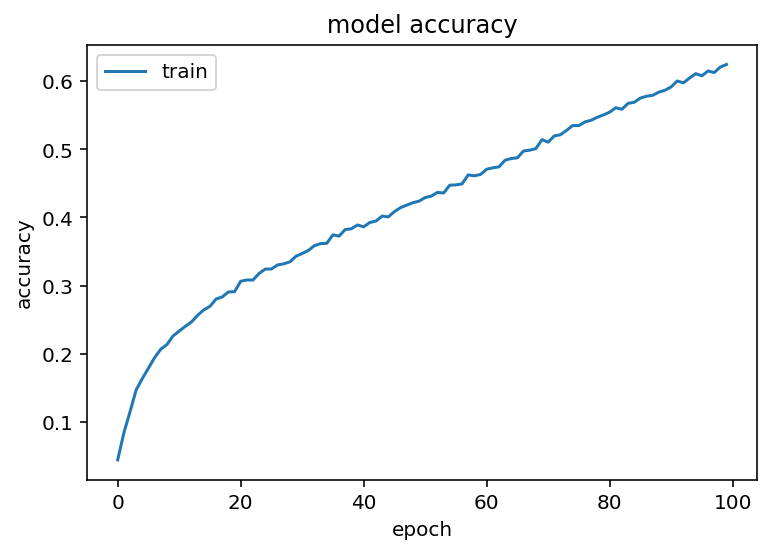

In [11]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
model.save("music.hdf5")

In [0]:
# generating music 

backward_dict = dict()
for note in note_dict.keys():
  index = note_dict[note]
  backward_dict[index] = note

n = np.random.randint(0, len(input_notes)-1)
sequence = input_notes[n]
start_sequence = sequence.reshape(1, sequence_length, vocab_length)
output = []

for i in range(0, 100):
  newNote = model.predict(start_sequence, verbose=0)
  # Get the position with the highest probability
  index = np.argmax(newNote)
  encoded_note = np.zeros((vocab_length))
  encoded_note[index] = 1
  output.append(encoded_note)
  sequence = start_sequence[0][1:]
  start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
  start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)


In [16]:
from music21 import note

finalNotes = [] 
for element in output:
    index = list(element).index(1)
    finalNotes.append(backward_dict[index])
    
offset = 0
output_notes = []

for pattern in finalNotes:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'